In [307]:
# Paketler
import glob   #Dosyaları çekmek için 
import pandas as pd  #Data framler ile işlem yapmak için
import numpy as np  #Matematiksel işlemler ve diziler için
import matplotlib.pyplot as plt #Çizim ve grafikler için
from tqdm import tqdm  #Akıllı bir ilerleme  göstergesi için
import cv2 #Resim işleme için
from skimage.feature import greycomatrix, greycoprops #özellik çıkarımı için

In [308]:
ims1 = 500 #Resim boyutu
tts = 0.22  #Test ayırma yüzdesi

In [309]:
#resmin renk ayarı
def cvt_image_colorspace(image, colorspace = cv2.COLOR_BGR2GRAY):
    return cv2.cvtColor(image, colorspace)


#medyan filtre
def median_filtering(image, kernel_size=3):
    '''
    :image parametresi: gri skala resim
    :kernel_size parametresi: kernel sayısı tek sayı olmalı
    :return: bulanık resim
    '''

    return cv2.medianBlur(image, kernel_size)


#treshold uygulama
def apply_threshold(image, **kwargs):
    '''
    :param image: image object
    :param kwargs: threshold parametreleri - sözlük olarak
    :return:
    '''
    threshold_method = kwargs['threshold_method']
    max_value = kwargs['pixel_value']
    threshold_flag = kwargs.get('threshold_flag', None)
    if threshold_flag is not None:
        ret, thresh1 = cv2.adaptiveThreshold(image, max_value, threshold_method,cv2.THRESH_BINARY, kwargs['block_size'], kwargs['const'])
    else:
        ret, thresh1 = cv2.threshold(image, kwargs['threshold'], max_value, threshold_method)
    return thresh1



Text(0.5, 1.0, 'treshold uygulandı')

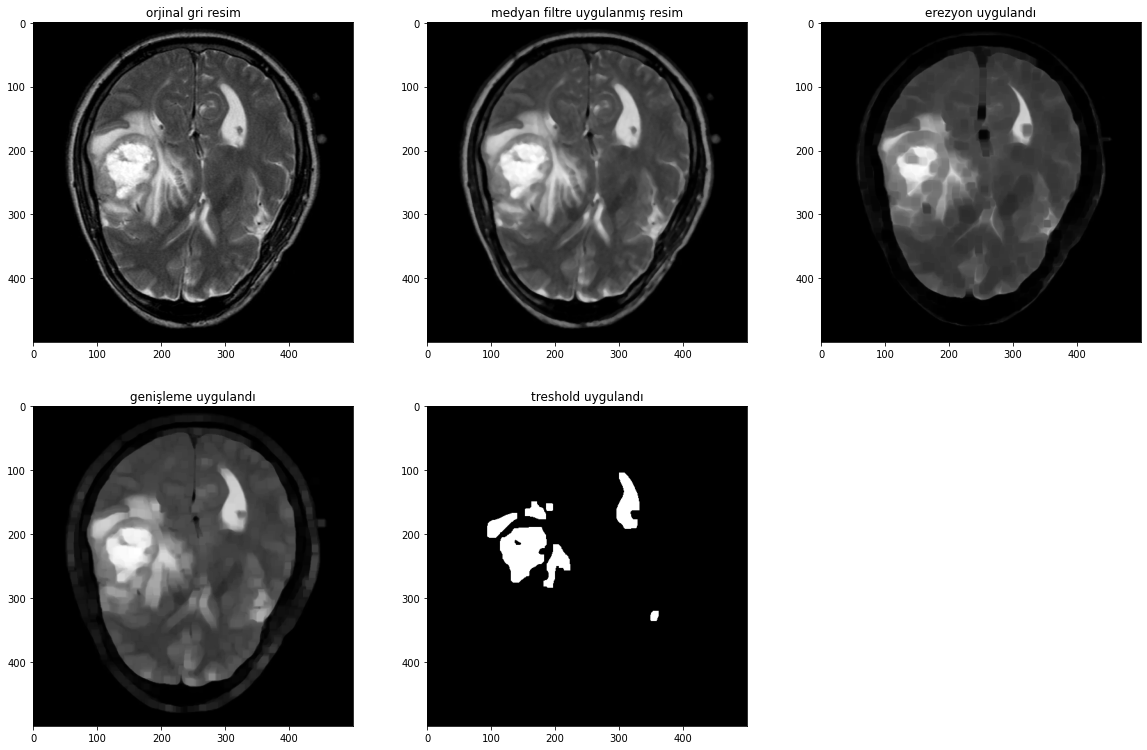

In [310]:
#Görüntü işleme ile Tümörlü MR görüntülerinde tümörlü bölgeyi çıkardık 

filename = './drive/My Drive/beyin-tumor-veri/yes/y100.jpg'
fig = plt.figure(figsize = (20,20))

image = cv2.imread(filename,1)
image = cv2.resize(image,(ims1,ims1))

grayscale_img = cvt_image_colorspace(image)
median_filtered = median_filtering(grayscale_img,5)

kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
erosion = cv2.morphologyEx(median_filtered, cv2.MORPH_ERODE, kernel)
dilation = cv2.morphologyEx(erosion, cv2.MORPH_DILATE, kernel)
new_thresholding = apply_threshold(dilation,  **{"threshold" :160,
                                                 "pixel_value" : 255,
                                                 "threshold_method" : cv2.THRESH_BINARY})


ax2 = fig.add_subplot(3,3,1)
ax2.imshow(grayscale_img,cmap=plt.get_cmap('gray'))
ax2.set_title('orjinal gri resim')

ax3 = fig.add_subplot(3,3,2)
ax3.imshow(median_filtered,cmap=plt.get_cmap('gray'))
ax3.set_title('medyan filtre uygulanmış resim')

ax4 = fig.add_subplot(3,3,3)
ax4.imshow(erosion,cmap=plt.get_cmap('gray'))
ax4.set_title('erezyon uygulandı')

ax5 = fig.add_subplot(3,3,4)
ax5.imshow(dilation,cmap=plt.get_cmap('gray'))
ax5.set_title('genişleme uygulandı')

ax6 = fig.add_subplot(3,3,5)
ax6.imshow(new_thresholding,cmap=plt.get_cmap('gray'))
ax6.set_title('treshold uygulandı')

In [311]:
# Verileri dosyadan alma
def importing_data(path):

    featureimage = []
    original = []

    for filename in tqdm(glob.glob(path)):
       
        ds = []
        cr = []
        cn = []
        am = []
        en = []
        ho = []

        image = cv2.imread(filename,1) 
    
        image = cv2.resize(image,(ims1,ims1))


        # resmi griye çevirdik
        grayscale_img = cvt_image_colorspace(image)

        #medyan filtresi uyguladık
        median_filtered = median_filtering(grayscale_img,5)


        #erezyon ve genişleme uygulandı
        #tümör bölgesini erezyon ve genişleme ile belirtmeye çalıştık

        kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
        erosion = cv2.morphologyEx(median_filtered, cv2.MORPH_ERODE, kernel)

        dilation = cv2.morphologyEx(erosion, cv2.MORPH_DILATE, kernel)
        
        
        #özellik çıkarımı
        #doku özelliklerini çıkarmak için
        glcm = greycomatrix(dilation, [5], [0], symmetric=True, normed=True)
        ds.append(greycoprops(glcm, 'dissimilarity')[0,0]) #farklılık değeri
        cr.append(greycoprops(glcm, 'correlation')[0,0])  #korelasyon değeri
        cn.append(greycoprops(glcm, 'contrast')[0,0])     #kontrast değeri
        am.append(greycoprops(glcm, 'ASM')[0,0])          #ASM değeri
        en.append(greycoprops(glcm, 'energy')[0,0])       #enerji değeri
        ho.append(greycoprops(glcm, 'homogeneity')[0,0])  #homojenlik değeri

        featureimage.append([ds,cr,cn,am,en,ho])
        image= np.array(image).ravel()
        original.append(image)
     
    return featureimage,original

path1 = './drive/My Drive/beyin-tumor-veri/no/*.jpg'
path2 = './drive/My Drive/beyin-tumor-veri/yes/*.jpg'

print("importing training no")
train_n,original_n = importing_data(path1)
print("importing training yes")
train_y,original_y = importing_data(path2)

importing training no


100%|██████████| 1500/1500 [00:25<00:00, 59.20it/s]


importing training yes


100%|██████████| 1500/1500 [00:27<00:00, 54.92it/s]


Text(0.5, 1.0, 'Original Affected gray')

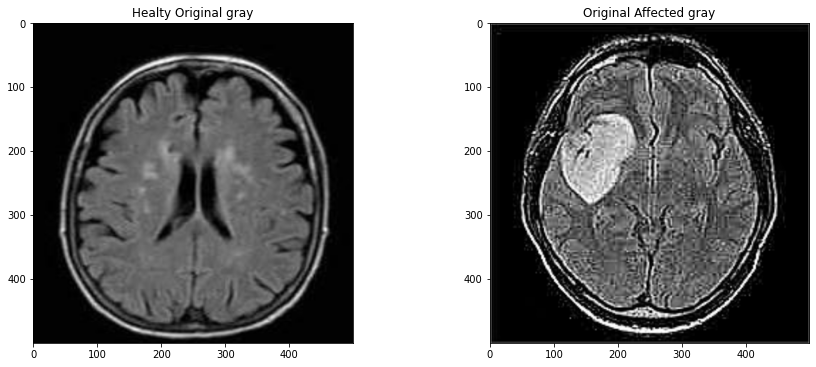

In [333]:
fig = plt.figure(figsize = (15,20))

ax1 = fig.add_subplot(3,2,1)
ax1.imshow(np.reshape(original_n[40],(ims1,ims1,3)),cmap=plt.get_cmap('gray'))
ax1.set_title('Healty Original gray')

ax2 = fig.add_subplot(3,2,2)
ax2.imshow(np.reshape(original_y[32],(ims1,ims1,3)),cmap=plt.get_cmap('gray'))
ax2.set_title('Original Affected gray')

In [312]:
tempdf_no = pd.DataFrame()
tempdf_yes = pd.DataFrame()

df_train_n = pd.DataFrame()
df_train_y = pd.DataFrame() 

In [313]:
#sağlıklı verilerimizi data frame çevirdik

for i in range(1500):
  tempdf_no ['dissimilarity'] = train_n[i][0]
  tempdf_no ['correlation'] = train_n[i][1]
  tempdf_no ['contrast'] = train_n[i][2]
  tempdf_no ['ASM'] = train_n[i][3]
  tempdf_no ['energy'] = train_n[i][4]
  tempdf_no ['homogeneity'] = train_n[i][5]
  df_train_n = df_train_n.append(tempdf_no, ignore_index = True)

df_train_n['label'] = 'Healthy'

In [314]:
#son 5 değeri gösterdik
df_train_n.tail()

,dissimilarity,correlation,contrast,ASM,energy,homogeneity,label
1495,6.889867,0.907028,273.929810,0.005283,0.072686,0.442543,Healthy
1496,9.985863,0.919132,393.633216,0.013816,0.117542,0.383685,Healthy
1497,6.707265,0.965959,498.567685,0.305750,0.552947,0.684784,Healthy
1498,5.386541,0.910911,143.627794,0.066533,0.257941,0.543221,Healthy
1499,5.795790,0.957552,214.691491,0.051235,0.226350,0.560353,Healthy


In [315]:
#hastalıklı verilerimizi data frame çevirdik

for i in range(1500):
  tempdf_yes ['dissimilarity'] = train_y[i][0]
  tempdf_yes ['correlation'] = train_y[i][1]
  tempdf_yes ['contrast'] = train_y[i][2]
  tempdf_yes ['ASM'] = train_y[i][3]
  tempdf_yes ['energy'] = train_y[i][4]
  tempdf_yes ['homogeneity'] = train_y[i][5]
  df_train_y = df_train_y.append(tempdf_yes, ignore_index = True)

df_train_y['label'] = 'Affected'

In [316]:
df_train_y.tail()

,dissimilarity,correlation,contrast,ASM,energy,homogeneity,label
1495,4.775067,0.978036,113.814687,0.009397,0.096941,0.511046,Affected
1496,5.931721,0.965632,195.118436,0.074664,0.273248,0.518699,Affected
1497,16.026558,0.819975,1205.834275,0.000843,0.029041,0.343605,Affected
1498,15.665729,0.869992,1847.221236,0.112199,0.334962,0.538444,Affected
1499,5.876016,0.947616,205.118141,0.040886,0.202202,0.566464,Affected


In [317]:
#Birleştirme İşlemi
train_data = df_train_n.append(df_train_y,ignore_index=True)

In [318]:
train_data

,dissimilarity,correlation,contrast,ASM,energy,homogeneity,label
0,5.816566,0.957387,215.402804,0.051889,0.227792,0.554466,Healthy
1,8.417604,0.905679,275.082315,0.044855,0.211790,0.480166,Healthy
2,11.625810,0.927723,834.092590,0.150886,0.388440,0.567289,Healthy
3,6.650432,0.881036,427.828065,0.073142,0.270448,0.632182,Healthy
4,13.174376,0.926573,894.243305,0.079862,0.282598,0.517165,Healthy
...,...,...,...,...,...,...,...
2995,4.775067,0.978036,113.814687,0.009397,0.096941,0.511046,Affected
2996,5.931721,0.965632,195.118436,0.074664,0.273248,0.518699,Affected
2997,16.026558,0.819975,1205.834275,0.000843,0.029041,0.343605,Affected
2998,15.665729,0.869992,1847.221236,0.112199,0.334962,0.538444,Affected


In [319]:
# X(image) ve Y(label) verilerimiz ayırdık

x_train = train_data.drop('label',axis=1)
y_train = train_data['label']

In [320]:
x_train.head()

,dissimilarity,correlation,contrast,ASM,energy,homogeneity
0,5.816566,0.957387,215.402804,0.051889,0.227792,0.554466
1,8.417604,0.905679,275.082315,0.044855,0.211790,0.480166
2,11.625810,0.927723,834.092590,0.150886,0.388440,0.567289
3,6.650432,0.881036,427.828065,0.073142,0.270448,0.632182
4,13.174376,0.926573,894.243305,0.079862,0.282598,0.517165


In [321]:
#normalizasyon işlemi yaptık verilerimizi 0-1 aralığına indirgedik 
x_traind = ((x_train-np.min(x_train))/(np.max(x_train)-np.min(x_train)))
x_traind.head()

,dissimilarity,correlation,contrast,ASM,energy,homogeneity
0,0.205355,0.903637,0.068033,0.093457,0.286768,0.525086
1,0.346673,0.705189,0.092818,0.080680,0.264585,0.392421
2,0.520978,0.789792,0.324971,0.273276,0.509476,0.547983
3,0.250660,0.610613,0.156252,0.132061,0.345903,0.663852
4,0.605113,0.785377,0.349951,0.144266,0.362746,0.458484


In [322]:
# Sağlıklılara 0 değeri Hasta olanlara 1 değerini atadık

y_traind = []
for i in range(len(y_train)):
    if(y_train[i]=="Healthy"):
        y_traind.append(0)
    else:
        y_traind.append(1)
print(len(y_traind))

3000


In [323]:
# test ve öğrenme verilerini parçaladık
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_traind, y_traind, test_size=tts,random_state=58)
print('Train size: {train}, Test size: {test}'.format(train=len(x_train), test=len(x_test)))

Train size: 2340, Test size: 660


In [324]:
from sklearn.tree import DecisionTreeClassifier 
classifier = DecisionTreeClassifier(criterion = 'entropy',random_state=58)
classifier.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=58)

In [325]:
y_pred = classifier.predict(x_test)

In [326]:
y_pred[0:10]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0])

In [327]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[312  26]
 [ 32 290]]


In [328]:
classifier.score(x_test, y_test)

0.9121212121212121

In [329]:
# parametremetre optimizasyonu ve algoritma seçimi
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 

classifier1 = DecisionTreeClassifier(random_state=58)


p = {'criterion': ['entropy','gini'],
     'max_features': ['sqrt', 'log2',None],
     'splitter':['random','best'] 
     }

'''
GSCV parametreleri
estimator : sınıflandırma algoritması (neyi optimize etmek istediğimiz)
param_grid : parametreler/ denenecekler
scoring: neye göre skorlanacak : örn : accuracy
cv : kaç katlamalı olacağı
n_jobs : aynı anda çalışacak iş
'''
gs = GridSearchCV(estimator= classifier1, #desicion tree algoritması
                  param_grid = p,
                  scoring =  'accuracy',
                  verbose=1,
                  cv = 10 )

grid_search = gs.fit(x_train,y_train)
eniyisonuc = grid_search.best_score_
eniyiparametreler = grid_search.best_params_
#grid_search.best_estimator_

print(eniyisonuc)
print(eniyiparametreler)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
0.9055555555555557
{'criterion': 'entropy', 'max_features': None, 'splitter': 'random'}
